In [ ]:
import gpflow 
import numpy as np
import scipy.spatial as spatial
import matplotlib
import pandas as pd
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 12)
plt = matplotlib.pyplot

In [22]:
N = 12
X = np.random.rand(N,2)
Y = np.sin(12*X[:,0]).reshape([12,1]) + 0.66*np.cos(25*X[:,0]).reshape([12,1]) + np.random.randn(N,1)*0.1 + 3
#plt.plot(X, Y, 'kx', mew=2)
#plt.show()
X.shape

(12, 2)

In [3]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3) #el 1 representa la dimension del input
m = gpflow.models.GPR(X, Y, kern=k)
m.likelihood.variance = 0.01

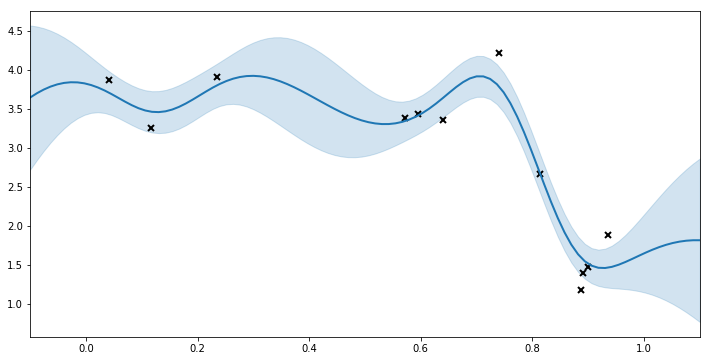

In [5]:

def plot(m):
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    plt.xlim(-0.1, 1.1)

plot(m)



In [32]:
k = gpflow.kernels.Matern52(2, lengthscales=0.3)
meanf = gpflow.mean_functions.Linear()
model = gpflow.models.GPR(X, Y, k)#, meanf)
model.likelihood.variance = 0.01

In [33]:
Y.shape

(12, 1)

In [34]:
print(model)

                             class prior transform  trainable shape  \
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape value  
GPR/kern/variance               True   1.0  
GPR/kern/lengthscales           True   0.3  
GPR/likelihood/variance         True  0.01  


C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\gpflow\misc.py:30: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = df.reindex_axis(keys, axis=1)


In [35]:
gpflow.train.ScipyOptimizer().minimize(model)
#plot(model)
print(model)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 20.474069
  Number of iterations: 21
  Number of functions evaluations: 25
                             class prior transform  trainable shape  \
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                  value  
GPR/kern/variance               True      9.072787427434852  
GPR/kern/lengthscales           True      0.444144698807303  
GPR/likelihood/variance         True  5.857987445948388e-06  


C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\gpflow\misc.py:30: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = df.reindex_axis(keys, axis=1)


In [10]:
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = gpflow.priors.Gaussian(0., 10.)
m.compile()
print(m)

                             class          prior transform  trainable  \
GPR/mean_function/A      Parameter  N([0.],[10.])    (none)       True   
GPR/mean_function/b      Parameter  N([0.],[10.])    (none)       True   
GPR/kern/variance        Parameter  Ga([1.],[1.])       +ve       True   
GPR/kern/lengthscales    Parameter  Ga([1.],[1.])       +ve       True   
GPR/likelihood/variance  Parameter  Ga([1.],[1.])       +ve       True   

                          shape  fixed_shape                   value  
GPR/mean_function/A      (1, 1)         True  [[-2.501079963095747]]  
GPR/mean_function/b          ()         True       4.792441957753011  
GPR/kern/variance            ()         True     0.43872734712577477  
GPR/kern/lengthscales        ()         True     0.07574791497324346  
GPR/likelihood/variance      ()         True    0.015257519215429605  


C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\gpflow\misc.py:30: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = df.reindex_axis(keys, axis=1)


In [13]:
sampler = gpflow.train.HMC()
samples = sampler.sample(m, num_samples=1000, epsilon=0.05, lmin=10, lmax=20, logprobs=False)

Text(0,0.5,'parameter value')

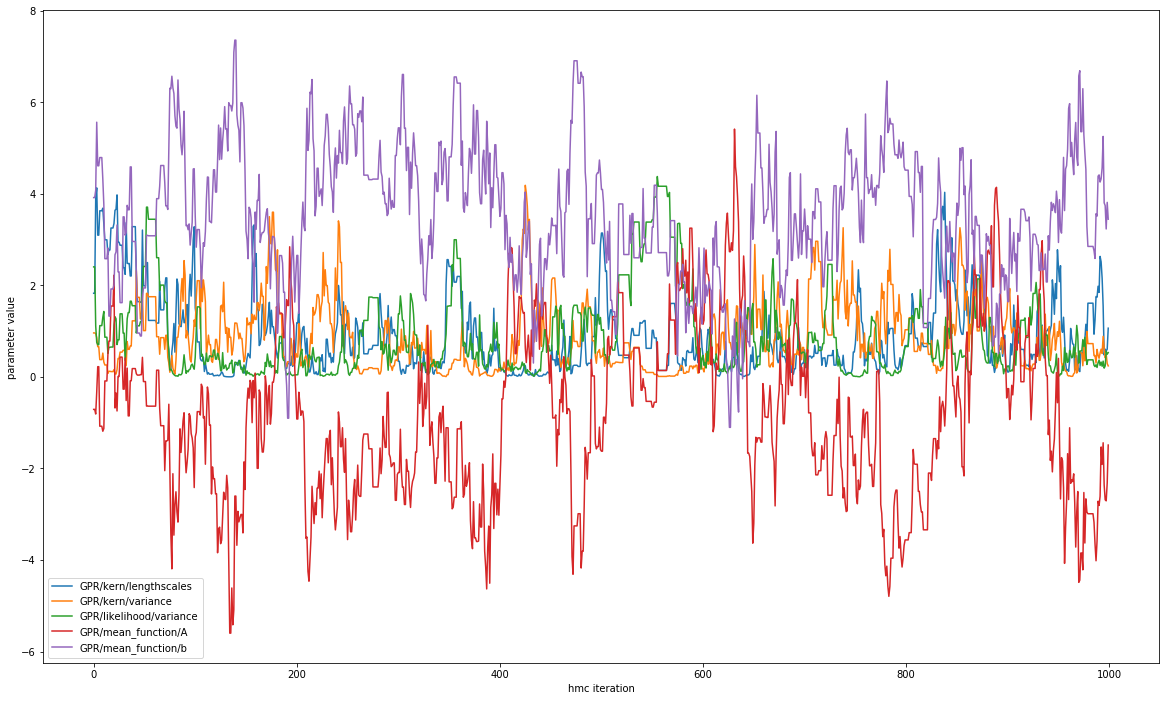

In [16]:
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')

In [2]:
def get_data_dhid_test_point(dhid, test_point, distancia, train_data):
    # Esta funcion retorna una tupla X,y
    # de modo que X no contiene puntos del
    # sondaje de id dhid, y adem'as retorna
    # solo los X dentro de una esfera de radio
    # distancia entorno a test_point

    # X_dhid = train_data.loc[train_data['dhid']==dhid][['midx','midy','midz']].as_matrix()
    dhid_bool = train_data['dhid'] != dhid
    train_data_dhid = train_data[dhid_bool]
    X_train = train_data_dhid[['midx','midy','midz']].as_matrix()
    y = train_data_dhid[['au']].as_matrix()
    #X_train = train_data.loc[train_data['dhid'] != dhid][['midx', 'midy', 'midz']].as_matrix()
    #y = train_data.loc[train_data['dhid'] != dhid]['au'].as_matrix()
    
    # tree_X_dhid = spatial.cKDTree(X_dhid)
    tree_test = spatial.cKDTree(X_train)
    # pairsList = tree_X_dhid.query_ball_tree(tree_test,distancia)
    idx = tree_test.query_ball_point(list(test_point), distancia)  # como se hace para
    # un punto no se repiten
    # idx = list(set(x for l in pairsList for x in l)) # indices de los puntos test
    # que se encuentran a <= distancia
    
    trainable =False
    if len(idx) >= 20:
        trainable == True
    return X_train[idx, :], y[idx], trainable

def get_df_dhid_test_point(dhid, test_point, distancia, train_data):
    # Esta funcion retorna una tupla X,y
    # de modo que X no contiene puntos del
    # sondaje de id dhid, y adem'as retorna
    # solo los X dentro de una esfera de radio
    # distancia entorno a test_point
    
    dhid_bool = train_data['dhid'] != dhid
    train_data_dhid = train_data[dhid_bool]
    X_train_dhid = train_data_dhid[['dhid','midx','midy','midz']]
    X_train = train_data_dhid[['midx','midy','midz']].as_matrix()
    y = train_data_dhid[['au']].as_matrix()
    
    train_tree = spatial.cKDTree(X_train)
    
    idx = train_tree.query_ball_point(list(test_point), distancia)  # como se hace para
    
    trainable =False
    if X_train_dhid.iloc[idx,:].shape[0] >= 20:
        trainable = True
    return X_train_dhid.iloc[idx,:], y[idx], trainable

def get_dhids():
    df = pd.read_csv('../../GP_Data/cy17_spc_au_rl6_entry.csv')
    df_dhid = df['dhid']
    seen = set()
    DHID = []
    for item in df_dhid:
        if item not in seen:
            seen.add(item)
            DHID.append(item)
    return DHID

def get_au_xyz_by_dhid(dhid):
    train_data = pd.read_csv('../../GP_Data/cy17_spc_au_rl6_entry.csv')
    xyz_au = train_data.loc[train_data['dhid'] == dhid][['midx','midy','midz','au']].as_matrix()
    return xyz_au

In [14]:
gpflow.__version__

'1.1.0'

In [46]:
def main_jupyter(modelo,k, Plotear = False):
    # se cargan los sondajes y se obtienen los dhid
    train_data = pd.read_csv('../../GP_Data/cy17_spc_au_rl6_entry.csv')
    DHIDs = get_dhids()

    # se cargan los datos de prueba
    test_data = pd.read_csv('../../GP_Data/ok_au.csv')
    data_matrix = test_data[['xcentre', 'ycentre', 'zcentre', 'au']].as_matrix()
    data_matrix = data_matrix[data_matrix[:, 3] > 0]  # notar que donde no se estimo se ingresa -99
    X_test = data_matrix[:, :3]

    # se setea el path para guardar predicciones
    path_csv = 'C:\\Users\\jpdon\\Desktop\\BHP2018\\GP_nb\\GP_Data\\'
    nombre = 'gp_au'

    # se define el objeto dataFrame que almacenara las predicciones
    cols_names = ['dhid', 'midx', 'midy', 'midz', 'au_gp', 'sigma']
    df = pd.DataFrame(columns=cols_names)
    df_pred_med = pd.DataFrame(columns = ['y_pred','y_med','trained'])

    # se define la distancia a la cual se buscan los sondajes para entrenar
    distancia = 100

    y_preds_tot = list()
    y_meds_tot = list()
    train_dicc = dict()
    dicc_preds = dict()
    #for dhid in DHIDs[100:104]:
    for dhid in ['SPD1647']:
        # for dhid in ['N0440']:
        # se inicializan
        print('Se ajusta el modelo para id: {}\n'.format(dhid))

        y_preds = list()
        y_medido = list()

        X_dhid = train_data.loc[train_data['dhid'] == dhid][['midx', 'midy', 'midz']].as_matrix()
        y_medido_matrix = train_data.loc[train_data['dhid'] == dhid][['au']].as_matrix()
        y_medido.extend(list(y_medido_matrix))
        print('Puntos a estimar:{}'.format(X_dhid.shape[0]))
        print('\n')
        for test_point in X_dhid:
            X, y, trainable = get_data_dhid_test_point(dhid, test_point, distancia, train_data)
            
            X_std = (X - X.mean()) / X.std()
            y_std = (y - y.mean()) / y.std()
            
            # se guardan en un diccionario test_point:X los puntos de entrenamiento
            key_point = '[{},{},{} ]'.format(int(test_point[0]),int(test_point[1]),int(test_point[2]))
            
            # sparse GP es mas rapido al parecer
            if modelo == 'GPR':
                m = gpflow.models.GPR(X_std, y_std, k)
            elif modelo == 'SGPR':
                Zinit = X[:M,:]
                m = gpflow.models.SGPR(X_std, y_std, k, Zinit)
            else:
                print('Un modelo necesita ser especificado.')
                return
            try:
                print('Datos de entrenamiento: {}'.format(X.shape[0]))
                #gp.fit(X, y)
                gpflow.train.ScipyOptimizer().minimize(m)
                #y_pred, sigma = gp.predict(test_point.reshape(1, -1), return_std=True)
                test_point_std = (test_point - X_dhid.mean()) / X_dhid.std()
                y_pred, sigma = m.predict_f(test_point_std.reshape(3,1).T)
                y_preds.extend(list(y_pred*y.std()+y.mean()))
            except ValueError:
                print('No hay datos de entrenamiento')
                y_pred = 0
                sigma = 0
                y_preds.extend(list([0]))
                return None, None, test_point
            except np.linalg.LinAlgError:
                print('La matriz definida por el kernel no es definida positiva')
                y_pred = 0
                sigma = 0
                y_preds.extend(list([0]))
                pass
            fila = []
            fila.extend([dhid])
            fila.extend(list(test_point))
            fila.extend([y_pred, sigma])

            df = df.append(pd.DataFrame([fila], columns=cols_names))


        y_preds = np.array(y_preds)
        y_medido = np.array(y_medido)
        dicc_preds[dhid] = y_preds
        # se analizan los resultados por dhid
        fig, ax = plt.subplots()
        ax.scatter(y_medido, y_preds, edgecolors=(0, 0, 0))
        ax.plot([y_medido.min(), y_medido.max()], [y_medido.min(), y_medido.max()], 'k--', lw=2)
        ax.set_xlabel('Medido')
        ax.set_ylabel('Prediccion')
        ax.set_title('DHID:%s, Kernel: %s' % (dhid,k.__class__.__name__))
        print('')
        print('#############################################################')
        print('')
    
    if Plotear:
        plt.show()
    
    # se guardan las predicciones en path_csv+nombre
    df.to_csv(path_csv + nombre + '.csv', sep=',')
    return y_preds, y_medido, dicc_preds

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82


Datos de entrenamiento: 98
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.056026
  Number of iterations: 21
  Number of functions evaluations: 29
Datos de entrenamiento: 110
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.083294
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 118
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 167.434806
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 126
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 178.786319
  Number of iterations: 1
  Number of functions

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 238.381758
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 168
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 238.381758
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 164
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 232.706002
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 165
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 234.124941
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 166
INFO:tensorflow:Optimization terminated with

Datos de entrenamiento: 122
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 173.110562
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 121
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 171.691623
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 123
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 174.529501
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 124
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.948440
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 124
INFO:tensorflow:

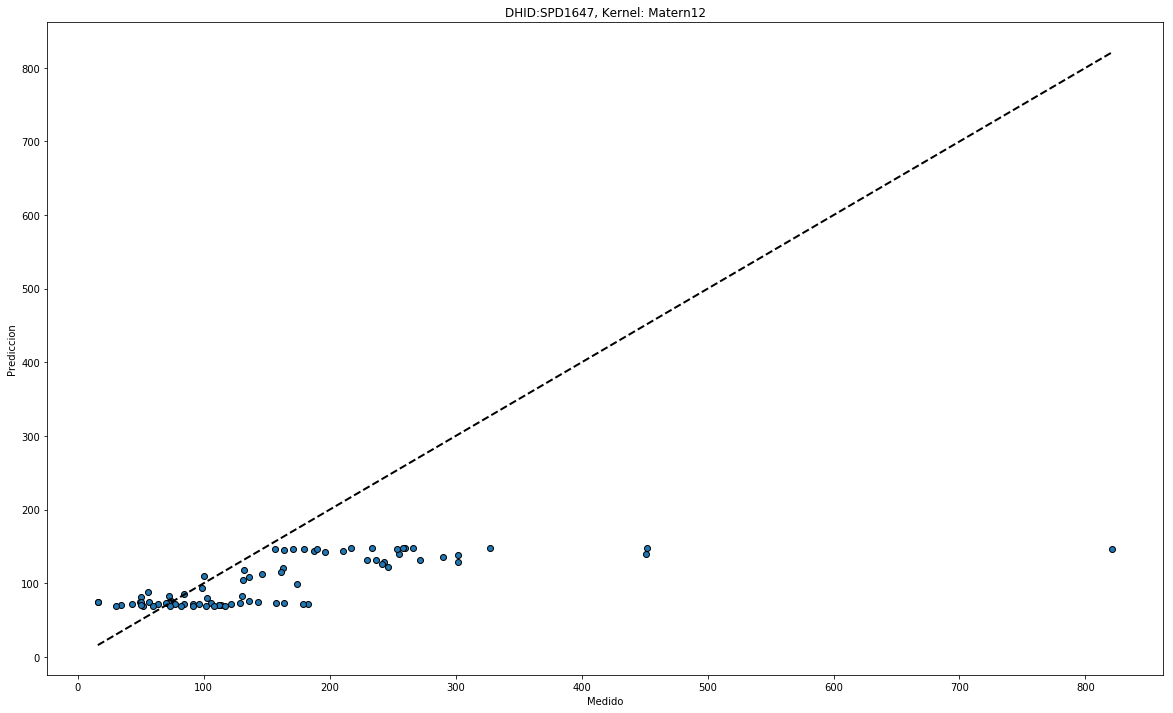

In [47]:
# Sparse GP usando kernel Matern12

M = 20
ker = gpflow.kernels.Matern12(3)
y_preds, y_medido, dicc_preds_matt12 = main_jupyter('GPR',ker, Plotear=True)

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82


Datos de entrenamiento: 98
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 139.056144
  Number of iterations: 23
  Number of functions evaluations: 26
Datos de entrenamiento: 110
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.083427
  Number of iterations: 6
  Number of functions evaluations: 7
Datos de entrenamiento: 118
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 167.434948
  Number of iterations: 5
  Number of functions evaluations: 7
Datos de entrenamiento: 126
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 178.786470
  Number of iterations: 4
  Number of function

Datos de entrenamiento: 168
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 238.381961
  Number of iterations: 4
  Number of functions evaluations: 6
Datos de entrenamiento: 164
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 232.706200
  Number of iterations: 4
  Number of functions evaluations: 6
Datos de entrenamiento: 165
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 234.125140
  Number of iterations: 4
  Number of functions evaluations: 6
Datos de entrenamiento: 166
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 235.544080
  Number of iterations: 4
  Number of functions evaluations: 6
Datos de entrenamiento: 164
INFO:tensorflow:Opti

Datos de entrenamiento: 121
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 171.691769
  Number of iterations: 4
  Number of functions evaluations: 6
Datos de entrenamiento: 123
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 174.529650
  Number of iterations: 4
  Number of functions evaluations: 6
Datos de entrenamiento: 124
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.948590
  Number of iterations: 4
  Number of functions evaluations: 6
Datos de entrenamiento: 124
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.948590
  Number of iterations: 4
  Number of functions evaluations: 6
Datos de entrenamiento: 126
INFO:tensorflow:

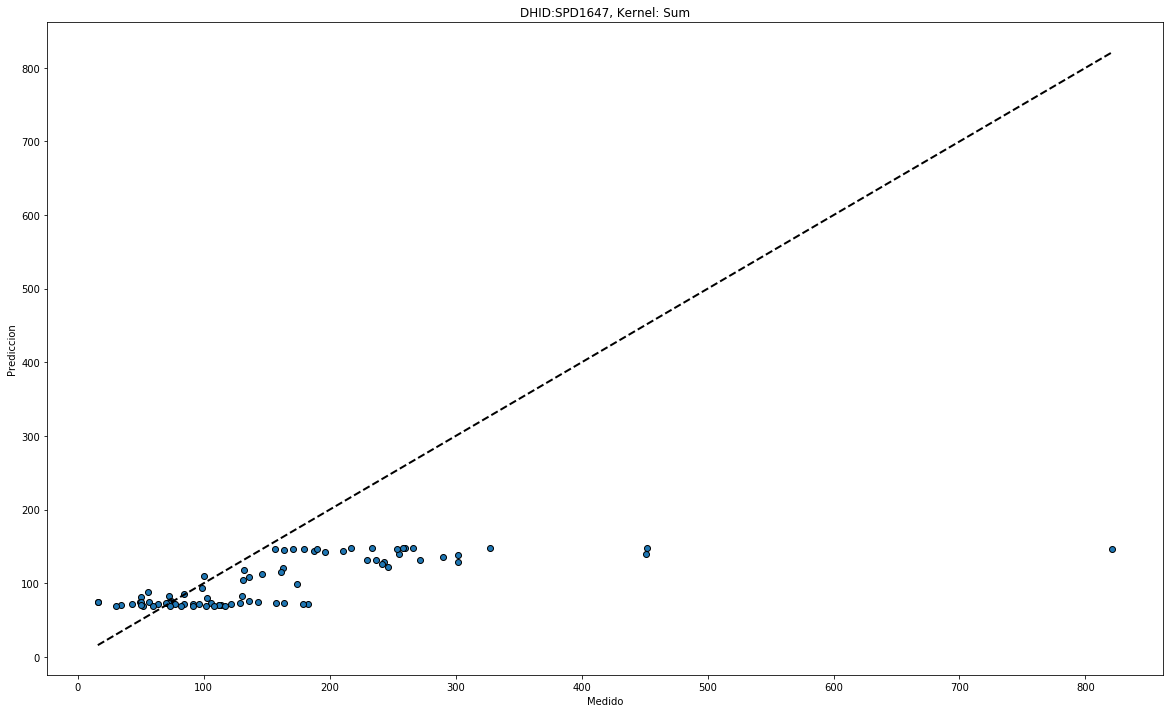

In [16]:
# Lo mismo de antes, pero ahora se con
# el GPR estandar de GPflow

k1 = gpflow.kernels.RBF(input_dim=1,active_dims=[0])
k2 = gpflow.kernels.RBF(input_dim=1,active_dims=[1])
k3 = gpflow.kernels.RBF(input_dim=1,active_dims=[2])
ker_3rbf = k1+k2+k3+gpflow.kernels.White(input_dim=1,active_dims=[2])
y_preds, y_medido, dicc_preds = main_jupyter('GPR',ker_3rbf,Plotear = True)

In [37]:
# 3BRF, pero ahora se agrega un kernel periodico
# en la tercera dimension
k1 = gpflow.kernels.RBF(input_dim=1,active_dims=[0])
k2 = gpflow.kernels.RBF(input_dim=1,active_dims=[1])
k3 = gpflow.kernels.RBF(input_dim=1,active_dims=[2])
k4 = gpflow.kernels.Periodic(input_dim = 1,active_dims=[2])
ker = k1+k2+k3+k4
y_preds, y_medido, dicc_preds_per = main_jupyter('SGPR', k = ker, Plotear=True)

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82


Datos de entrenamiento: 98
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.757058
  Number of iterations: 25
  Number of functions evaluations: 122
Datos de entrenamiento: 110
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 163.653521
  Number of iterations: 28
  Number of functions evaluations: 115
Datos de entrenamiento: 118
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 175.318041
  Number of iterations: 23
  Number of functions evaluations: 70
Datos de entrenamiento: 126
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 186.972137
  Number of iterations: 21
  Number of functions evaluations:

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 248.428013
  Number of iterations: 30
  Number of functions evaluations: 87
Datos de entrenamiento: 168
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 248.114728
  Number of iterations: 15
  Number of functions evaluations: 58
Datos de entrenamiento: 164
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 242.460174
  Number of iterations: 19
  Number of functions evaluations: 72
Datos de entrenamiento: 165
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 244.522675
  Number of iterations: 19
  Number of functions evaluations: 67
Datos de entrenamiento: 166
INFO:tensorflow:Optimization terminated 

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: 1850/SGPR/Cholesky = Cholesky[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](1850/SGPR/add_12)]]

Caused by op '1850/SGPR/Cholesky', defined at:
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-09a488bb979f>", line 8, in <module>
    y_preds, y_medido, dicc_preds_per = main_jupyter('SGPR', k = ker, Plotear=True)
  File "<ipython-input-36-62750214fb75>", line 57, in main_jupyter
    m = gpflow.models.SGPR(X_std, y_std, k, Zinit)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\gpflow\core\compilable.py", line 90, in __init__
    self.build()
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\gpflow\core\node.py", line 130, in build
    self._build()
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\gpflow\models\model.py", line 81, in _build
    likelihood = self._build_likelihood()
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\gpflow\decors.py", line 60, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\gpflow\models\sgpr.py", line 140, in _build_likelihood
    L = tf.cholesky(Kuu)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\tensorflow\python\ops\gen_linalg_ops.py", line 419, in cholesky
    "Cholesky", input=input, name=name)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\jpdon\Anaconda3\envs\lastGpFlow\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: 1850/SGPR/Cholesky = Cholesky[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](1850/SGPR/add_12)]]


In [39]:
# se corre una regresion con 3RBF en cada dimension
# con el modelo SGPR
M = 20
k1 = gpflow.kernels.RBF(input_dim=1,active_dims=[0])
k2 = gpflow.kernels.RBF(input_dim=1,active_dims=[1])
k3 = gpflow.kernels.Matern12(input_dim=1,active_dims=[2])
ker_3rbf = k1+k2+k3#+gpflow.kernels.White(input_dim=1,active_dims=[2])
y_preds, y_medido, dicc_preds_matt = main_jupyter('SGPR',ker_3rbf,Plotear = True)

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82


Datos de entrenamiento: 98
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.056123
  Number of iterations: 32
  Number of functions evaluations: 35
Datos de entrenamiento: 110
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 156.083404
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 118
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 167.434924
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 126
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 178.786444
  Number of iterations: 1
  Number of functions ev

Datos de entrenamiento: 168
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 238.381926
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 164
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 232.706166
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 165
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 234.125106
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 166
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 235.544046
  Number of iterations: 1
  Number of functions evaluations: 3
Datos de entrenamiento: 164
INFO:tensorflow:Opti


KeyboardInterrupt



In [40]:
# se cargan todos los datos de entrenamiento
# en dataFrame train_data
train_data = pd.read_csv('../../GP_Data/cy17_spc_au_rl6_entry.csv')

In [52]:
dhid_1 = 'SPD1643'
dhid_2 = 'SPD1644'
dhid_3 = 'SPD1647'
dhid_4 = 'SPD1645' 
distancia = 100
dhid = dhid_3
X_dhid = train_data.loc[train_data['dhid'] == dhid][['midx', 'midy', 'midz']].as_matrix()
X_dhid_std = (X_dhid - X_dhid.mean()) / X_dhid.std()
test_point_std = X_dhid_std[0]
test_point_std

array([-0.63675144,  1.41196664, -0.77515083])

In [53]:
(X_dhid[0] - X_dhid.mean()) / X_dhid.std()

array([-0.63675144,  1.41196664, -0.77515083])

In [ ]:
def plot_deriva_dhid(eje,dhid):
    eje_str = 'z'*(eje-1)*(int((eje)/2))+'x'*(1-eje)*int((2-eje)/2)+'y'*(2-eje)*(eje)
    xyz_au = get_au_xyz_by_dhid(dhid)
    n = xyz_au.shape[0]
    xx = xyz_au[:,eje]
    au = xyz_au[:,3]
    plt.scatter(xx,au,marker = 'x',s = 50,label = dhid)
    plt.title('Deriva por el eje %s para sondaje %s. (Puntos a estimar: %s)' % (eje_str,dhid,n))
    plt.xlabel('mid'+eje_str)
    plt.ylabel('au')
    plt.legend()
    return
def plot_estimacion(dicc,dhid,eje,etiqueta):
    eje_str = 'z'*(eje-1)*(int((eje)/2))+'x'*(1-eje)*int((2-eje)/2)+'y'*(2-eje)*(eje)
    xyz_au = get_au_xyz_by_dhid(dhid)
    xx = xyz_au[:,eje]
    au = dicc[dhid]
    plt.scatter(xx,au,marker = 'x',s = 50,label = 'Estimacion'+etiqueta)
    plt.legend()
    return
def plot_trainingSet_axis(dhid,eje,distancia):
    X_df,y = get_traningSet(dhid,distancia)
    n = X_df.shape[0]
    trainin_dhid = X_df['dhid']
    dhids = list(set(trainin_dhid))
    eje_str = 'z'*(eje-1)*(int((eje)/2))+'x'*(1-eje)*int((2-eje)/2)+'y'*(2-eje)*(eje)
    for current_dhid in dhids:
        zz = X_df.loc[X_df['dhid']==current_dhid][['mid'+eje_str]].as_matrix().astype(np.int)
        au_zz = y.loc[X_df['dhid']==current_dhid][['au']].as_matrix()
        plt.scatter(zz,au_zz,marker = 'x',s = 50,label = current_dhid)
        plt.xlabel('mid'+eje_str)
        plt.ylabel('au')
        plt.title('Puntos de entrenamiento para sondaje %s. (Puntos: %s)' % (dhid,n))
        plt.legend()
    return
def get_test_points_dhid(dhid):
    return train_data.loc[train_data['dhid'] == dhid][['midx', 'midy', 'midz']].as_matrix()

def get_traningSet(dhid,distancia):
    # retorna X dataFrame con los puntos de
    # entrenamiento para todo el sondaje dhid
    dhid_bool = train_data['dhid'] != dhid
    train_data_dhid = train_data[dhid_bool]
    X_train_dhid = train_data_dhid[['dhid','midx','midy','midz']]
    X_train = train_data_dhid[['midx','midy','midz']].as_matrix()
    y = train_data_dhid[['dhid','au']]
    
    test_points = get_test_points_dhid(dhid)
    test_tree = spatial.cKDTree(test_points)
    train_tree = spatial.cKDTree(X_train)
    
    idx_rep = test_tree.query_ball_tree(train_tree,distancia)
    idx_sin_rep = list(set([indice for lista in idx_rep for indice in lista]))
    
    return X_train_dhid.iloc[idx_sin_rep,:], y.iloc[idx_sin_rep,:]
# analisis de train_data = pd.read_csv('../../GP_Data/cy17_spc_au_rl6_entry.csv') au por cada dimension, para diferentes dhid
dhid_1 = 'SPD1643'
dhid_2 = 'SPD1644'
dhid_3 = 'SPD1647'
dhid_4 = 'SPD1645' 
distancia = 100
dhid = dhid_1
eje = 2
#diccionario = dicc_preds_per #diccionario con predicciones

# se grafica el sondaje a estimar vs eje
plt.figure()
plot_deriva_dhid(eje,dhid)

# se grafica la estimacion
plot_estimacion(dicc_preds,dhid,eje,'3 ker RBF')
#plot_estimacion(diccionario,dhid,eje,'RBF(x) + RBF(y) + Per(z) + RBF(z)')


# obtenemos los test points
test_points = get_test_points_dhid(dhid)

# se obtiene data frame con los puntos de entrenamiento
X_df,y = get_traningSet(dhid,distancia)
trainin_dhid = X_df['dhid']
dhids = list(set(trainin_dhid))

# se grafican los puntos de entrenamiento
# por eje
plt.figure()
plot_trainingSet_axis(dhid,eje,distancia)

# verificamos que los datos de entrenamiento
# sean, en efecto, los que ploteamos
plt.figure()
plot_deriva_dhid(1,'SPD2062')

plt.show()